# Example - Kickstarter

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Target" data-toc-modified-id="Target-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Target</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#Feature-Importance-migration" data-toc-modified-id="Feature-Importance-migration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance migration</a></span></li><li><span><a href="#Reverse-Learning-Curve" data-toc-modified-id="Reverse-Learning-Curve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reverse Learning Curve</a></span></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Performance comparison</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Feature-Impact" data-toc-modified-id="Feature-Impact-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Impact</a></span></li><li><span><a href="#Minimum-samples-by-period-effect" data-toc-modified-id="Minimum-samples-by-period-effect-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Minimum samples by period effect</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Domain classifier</a></span></li><li><span><a href="#Other-optimization-design-for-the-RF" data-toc-modified-id="Other-optimization-design-for-the-RF-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Other optimization design for the RF</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from aux_functions import *

np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
DATASETS_PATH = "~/Documents/datasets/animal_shelter/"
PREFIX = "animal_shelter"

In [5]:
intakes = pd.read_csv(DATASETS_PATH + "Austin_Animal_Center_Intakes.csv")
outcomes = pd.read_csv(DATASETS_PATH + "Austin_Animal_Center_Outcomes.csv")

In [6]:
intakes["Age upon Intake"] = intakes["Age upon Intake"].apply(lambda x: float(x.split(" ")[0]) / 12.0 if "month" in x else float(x.split(" ")[0]))
outcomes.rename(columns={"DateTime": "Outcome DateTime", "Outcome Type": "Outcome"},
                inplace=True)

data = intakes.merge(outcomes[["Animal ID", "Outcome DateTime", "Outcome"]], on="Animal ID")
data["time_until_adoption"] = (pd.to_datetime(data["Outcome DateTime"]) - pd.to_datetime(data["DateTime"])).dt.days
data["target"] = (data["time_until_adoption"] < 30) & (data["Outcome"] == "Adoption")
data["target"] = data["target"].astype(int)
data["target"].mean()

0.2998167402199117

In [7]:
data.shape

(160428, 16)

In [8]:
#data = data.sample(frac=0.10)

### Data

In [9]:
TIME_COLUMN = "Year"
TARGET = "target"

In [10]:
columns_to_label_encode = ["Intake Type", 
                           "Intake Condition",
                           "Animal Type",
                           "Sex upon Intake",
                           "Breed",
                           "Color"]

In [11]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

Intake Type
Intake Condition
Animal Type


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Sex upon Intake
Breed
Color


In [12]:
features = ["Age upon Intake"] + columns_to_label_encode

In [13]:
data["Year"] = pd.to_datetime(data["DateTime"]).apply(lambda x: int(x.year))

In [14]:
numerical_features = [f for f in features if f not in columns_to_label_encode]

In [15]:
data["Year"].value_counts()

2019    25595
2015    23981
2017    23741
2016    23565
2018    23409
2014    22803
2020    11404
2013     4936
2021      994
Name: Year, dtype: int64

In [16]:
training_start_year = 2014
training_end_year = 2017
holdout_end_year = 2020

In [17]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [18]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [19]:
train.shape

(75272, 17)

In [20]:
test.shape

(18818, 17)

In [21]:
out_of_time.shape

(61402, 17)

In [22]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Checking the support in the different environments

In [23]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Intake Type, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Intake Condition, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Animal Type, dtype: float64
Year
2014    1.0
2015    1.0
2016    1.0
2017    1.0
Name: Sex upon Intake, dtype: float64
Year
2014    0.580352
2015    0.560598
2016    0.429792
2017    0.413241
Name: Breed, dtype: float64
Year
2014    0.645435
2015    0.613588
2016    0.611465
2017    0.626327
Name: Color, dtype: float64


0.8533665917389023

In [24]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)

Year
2014    0.8
2015    0.9
2016    1.0
2017    0.9
Name: Age upon Intake_quant, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.9

### Benchmark

In [25]:
from pycaret.classification import *

In [26]:
TARGET

'target'

In [27]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=2, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6874,0.7817,0.7666,0.4708,0.5834,0.3554,0.3825
1,0.7006,0.7946,0.7866,0.4849,0.6000,0.3816,0.4102
2,0.6859,0.7772,0.7746,0.4696,0.5847,0.3557,0.3846
3,0.6942,0.7871,0.7840,0.4784,0.5942,0.3712,0.4004
4,0.6962,0.7905,0.7767,0.4803,0.5935,0.3719,0.3993
Mean,0.6929,0.7862,0.7777,0.4768,0.5912,0.3671,0.3954
SD,0.0055,0.0062,0.0071,0.0058,0.0063,0.0102,0.0104


In [28]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [29]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [30]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_sklearn"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_sklearn"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_sklearn"]))

0.7946691360135414
0.7872893826981108
0.7888780899420342


In [31]:
params_grid = {"n_estimators": [30, 60, 120], 
              "max_depth": [5, 10],
              "min_impurity_decrease": [1e-1, 1e-3, 0],
              "min_sample_periods": [5, 10, 30],
              "period_criterion": ["max", "avg"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")

# params_grid = {"n_estimators": [5], 
#               "max_depth": [5],
#               "min_impurity_decrease": [0.001],
#               "min_sample_periods": [5]}

['max', 'avg']

In [32]:
params_grid

{'n_estimators': [30, 60, 120],
 'max_depth': [5, 10],
 'min_impurity_decrease': [0.1, 0.001, 0],
 'min_sample_periods': [5, 10, 30],
 'period_criterion': ['max', 'avg']}

In [33]:
params_grid_benchmark

{'n_estimators': [30, 60, 120],
 'max_depth': [5, 10],
 'min_impurity_decrease': [0.1, 0.001, 0],
 'min_sample_periods': [5, 10, 30]}

In [34]:
DUMMY_TIME_COLUMN = "dummy_time_column"
train[DUMMY_TIME_COLUMN] = 1

In [35]:
# model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
#                                         multi=True)

# benchmark_opt_param = env_wise_hyper_opt(train[features + [DUMMY_TIME_COLUMN]], train[TARGET], 
#                                          model, 
#                                          DUMMY_TIME_COLUMN, 
#                                          params_grid_benchmark, 
#                                          cv=5,
#                                          score=roc_auc_score)

benchmark_opt_param = {'max_depth': 10,
 'min_impurity_decrease': 0,
 'min_sample_periods': 5,
 'n_estimators': 120}

In [36]:
benchmark_opt_param

{'max_depth': 10,
 'min_impurity_decrease': 0,
 'min_sample_periods': 5,
 'n_estimators': 120}

In [37]:
benchmark_model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       **benchmark_opt_param)

In [38]:
benchmark_model.fit(train[features + [DUMMY_TIME_COLUMN]], train[TARGET].values)

In [39]:
train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [40]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.7673351253108897
0.7481866039908384
0.7264530248147858


In [41]:
results = reverse_learning_curve(train, 
                                 out_of_time, 
                                 benchmark_model, 
                                 features, 
                                 TARGET,
                                 TIME_COLUMN, 
                                 roc_auc_score, 
                                 n_rounds=5,
                                 dummy_time_column=DUMMY_TIME_COLUMN)

In [42]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)

Age upon Intake     0.116295
Intake Type         0.012214
Intake Condition    0.000892
Animal Type        -0.000530
Sex upon Intake     0.003060
Breed               0.042276
Color               0.000000
Name: RF, dtype: float64

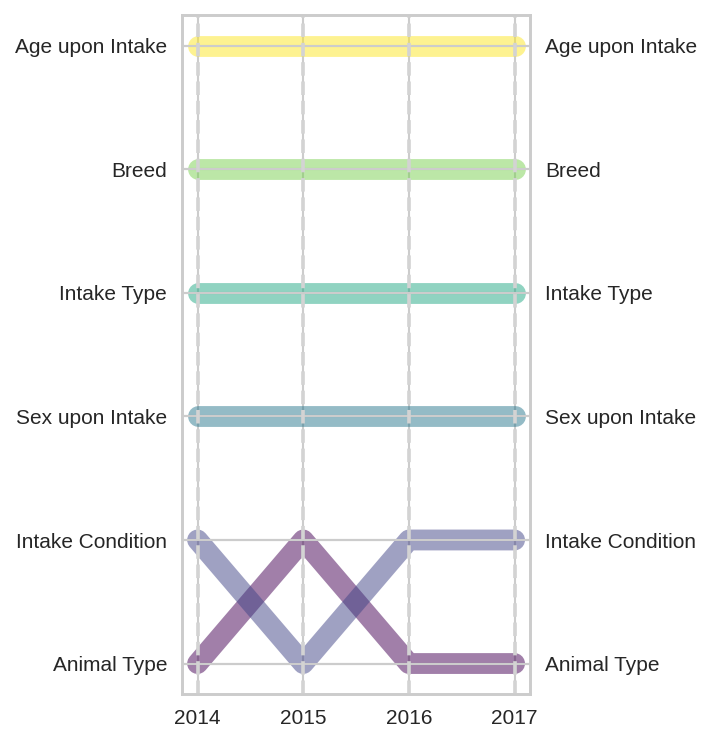

In [43]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, 
                                                                                             features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

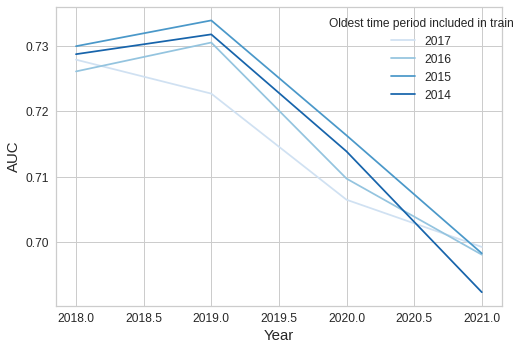

In [44]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [45]:
results

{'round': [],
 'holdout_performance': [0.7211997399588195,
  0.724299032649745,
  0.7283165230239673,
  0.7264530248147858],
 'feature_importance': [Age upon Intake     0.108452
  Intake Type         0.019745
  Intake Condition    0.002657
  Animal Type         0.000337
  Sex upon Intake     0.004218
  Breed               0.035344
  Color               0.000000
  Name: 2017, dtype: float64,
  Age upon Intake     0.116630
  Intake Type         0.016913
  Intake Condition    0.001990
  Animal Type        -0.000123
  Sex upon Intake     0.003362
  Breed               0.038338
  Color               0.000000
  Name: 2016, dtype: float64,
  Age upon Intake     0.114254
  Intake Type         0.016902
  Intake Condition   -0.000488
  Animal Type        -0.000778
  Sex upon Intake     0.002765
  Breed               0.040496
  Color               0.000000
  Name: 2015, dtype: float64,
  Age upon Intake     0.116295
  Intake Type         0.012214
  Intake Condition    0.000892
  Animal Type      

## Challenger model

In [46]:
train.reset_index(drop=True, inplace=True)

In [47]:
train[features + [TIME_COLUMN]]

,Age upon Intake,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Year
0,6.000000,4,5,2,2,2231,56,2015
1,2.000000,4,5,2,2,1982,252,2017
2,1.000000,4,5,1,0,1160,489,2017
3,0.583333,2,5,2,1,1278,9,2017
4,1.000000,3,5,2,4,1563,455,2016
...,...,...,...,...,...,...,...,...
75267,0.583333,4,5,2,1,2435,530,2017
75268,1.000000,4,6,1,5,1160,155,2014
75269,1.000000,4,5,2,1,822,416,2017
75270,0.500000,4,5,2,1,822,130,2014


In [48]:
train["Year"].value_counts()

2015    19136
2017    19000
2016    18852
2014    18284
Name: Year, dtype: int64

In [ ]:
# model = TimeForestClassifier(time_column=TIME_COLUMN,
#                                         multi=True)

# challenger_opt_param = env_wise_hyper_opt(train[features + [TIME_COLUMN]], 
#                                           train[TARGET], 
#                                           model, 
#                                           TIME_COLUMN,
#                                           params_grid,
#                                           cv=5,
#                                           score=roc_auc_score)

challenger_opt_param = {'max_depth': 10,
                         'min_impurity_decrease': 0,
                         'min_sample_periods': 5,
                         'n_estimators': 120,
                         'period_criterion': 'max'}

In [55]:
challenger_opt_param

{'max_depth': 10,
 'min_impurity_decrease': 0,
 'min_sample_periods': 5,
 'n_estimators': 120,
 'period_criterion': 'max'}

In [ ]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [56]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.7558592142945693
0.7452722063550372
0.7324899227004091


## Feature Importance migration

In [58]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

results_trt = reverse_learning_curve(train, 
                                     out_of_time, 
                                     challenger_model, 
                                     features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, challenger=True)

In [59]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)
challenger_model_importances

Age upon Intake     0.112227
Intake Type         0.012256
Intake Condition    0.001541
Animal Type         0.000040
Sex upon Intake     0.004491
Breed               0.052741
Color               0.000000
Name: TRF, dtype: float64

In [60]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

,RF,TRF
Age upon Intake,0.116295,0.112227
Intake Type,0.012214,0.012256
Intake Condition,0.000892,0.001541
Animal Type,-0.000530,0.000040
Sex upon Intake,0.003060,0.004491
Breed,0.042276,0.052741
Color,0.000000,0.000000


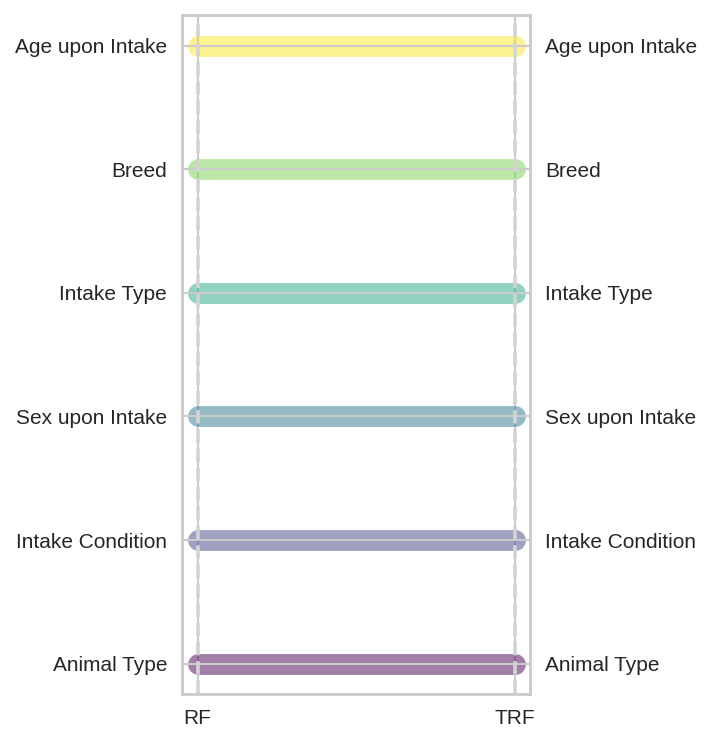

In [61]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

In [62]:
results_trt

{'round': [],
 'holdout_performance': [0.7211997399588195,
  0.729262149381017,
  0.7327062303002219,
  0.7324899227004091],
 'feature_importance': [Age upon Intake     0.094200
  Intake Type         0.015791
  Intake Condition    0.003048
  Animal Type         0.001290
  Sex upon Intake     0.005599
  Breed               0.036404
  Color               0.000000
  Name: 2017, dtype: float64,
  Age upon Intake     0.114484
  Intake Type         0.020574
  Intake Condition    0.001112
  Animal Type         0.001100
  Sex upon Intake     0.005519
  Breed               0.048490
  Color               0.000000
  Name: 2016, dtype: float64,
  Age upon Intake     0.112612
  Intake Type         0.014761
  Intake Condition    0.001675
  Animal Type         0.000580
  Sex upon Intake     0.005135
  Breed               0.051091
  Color               0.000000
  Name: 2015, dtype: float64,
  Age upon Intake     0.112227
  Intake Type         0.012256
  Intake Condition    0.001541
  Animal Type      

## Reverse Learning Curve

,2017,2016,2015,2014
Age upon Intake,0.094200,0.114484,0.112612,0.112227
Intake Type,0.015791,0.020574,0.014761,0.012256
Intake Condition,0.003048,0.001112,0.001675,0.001541
Animal Type,0.001290,0.001100,0.000580,0.000040
Sex upon Intake,0.005599,0.005519,0.005135,0.004491
Breed,0.036404,0.048490,0.051091,0.052741
Color,0.000000,0.000000,0.000000,0.000000


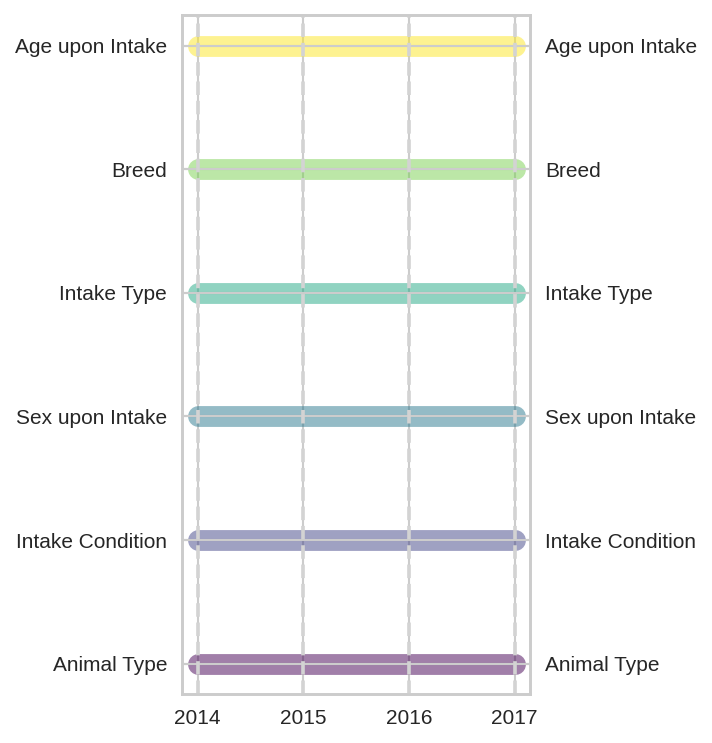

In [63]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

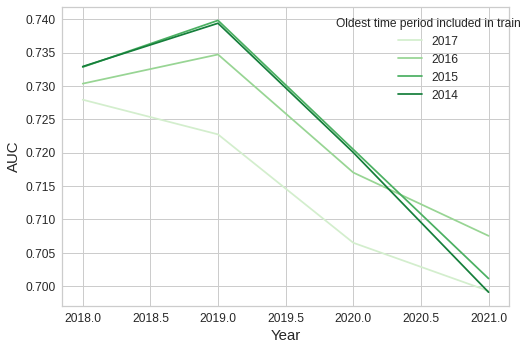

In [64]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

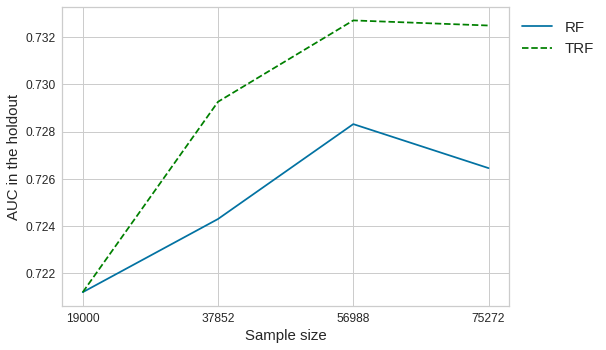

In [65]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

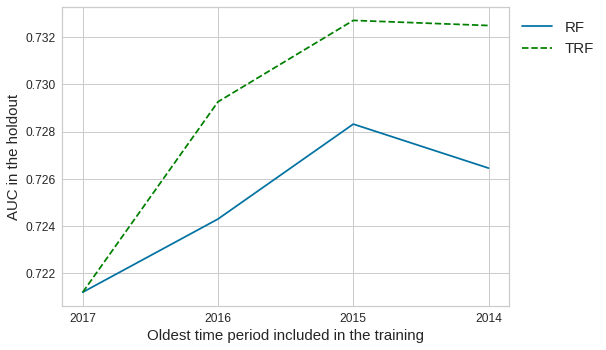

In [66]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

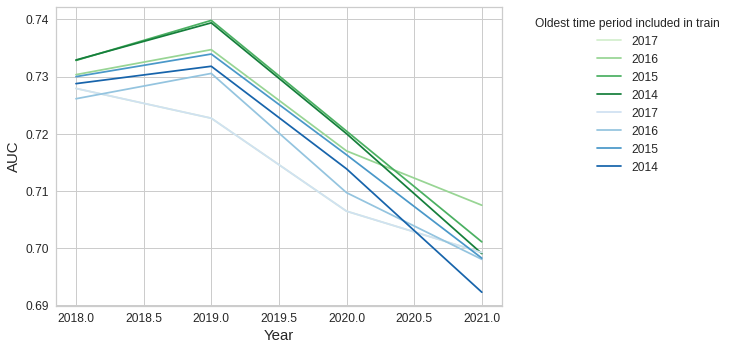

In [67]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

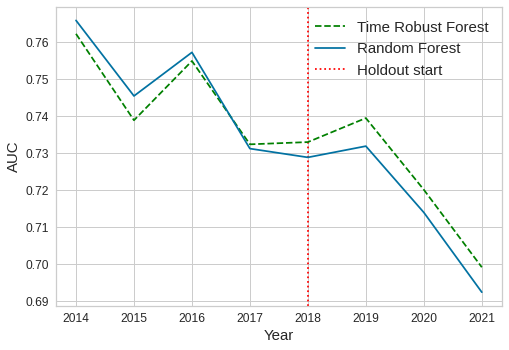

In [68]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

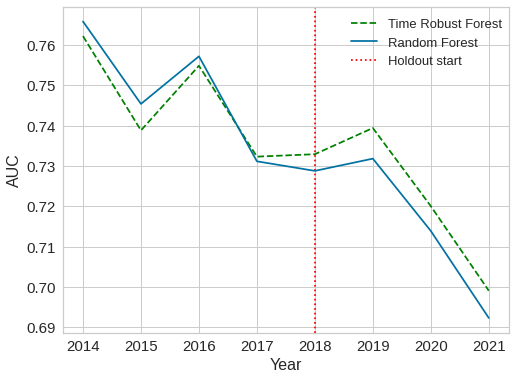

In [69]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, 
           bbox_to_anchor=(0.62, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [70]:
challenger_model.feature_importance()

,Importance
Feature,
Breed,21327
Age upon Intake,10132
Sex upon Intake,27
Intake Type,24
Animal Type,19
Intake Condition,13


In [71]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['Age upon Intake',
 'Intake Type',
 'Intake Condition',
 'Animal Type',
 'Sex upon Intake',
 'Breed']

In [72]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

['Age upon Intake',
 'Intake Type',
 'Intake Condition',
 'Animal Type',
 'Sex upon Intake',
 'Breed']

In [73]:
selected_features

['Age upon Intake',
 'Intake Type',
 'Intake Condition',
 'Animal Type',
 'Sex upon Intake',
 'Breed']

In [74]:
clf1 = setup(train[selected_features + [TARGET]], 
             target=TARGET,
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6886,0.7791,0.7685,0.4714,0.5843,0.3574,0.3848
1,0.6910,0.7808,0.7795,0.4743,0.5897,0.3647,0.3937
2,0.6890,0.7889,0.7898,0.4726,0.5913,0.3650,0.3965
3,0.6917,0.7916,0.7938,0.4754,0.5946,0.3702,0.4020
4,0.6906,0.7868,0.7821,0.4740,0.5902,0.3650,0.3946
Mean,0.6902,0.7855,0.7827,0.4735,0.5901,0.3645,0.3943
SD,0.0012,0.0048,0.0088,0.0014,0.0033,0.0041,0.0056


In [75]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [76]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [77]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.7980933774820653
0.7885408632599931
0.7896250381676017


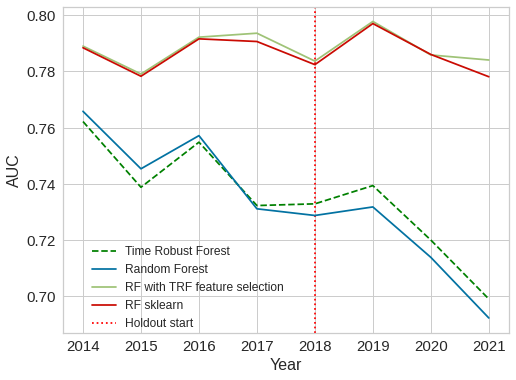

In [128]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="RF with TRF feature selection", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_sklearn"])).plot(label="RF sklearn", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=12, bbox_to_anchor=(0.52, 0.30))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [79]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

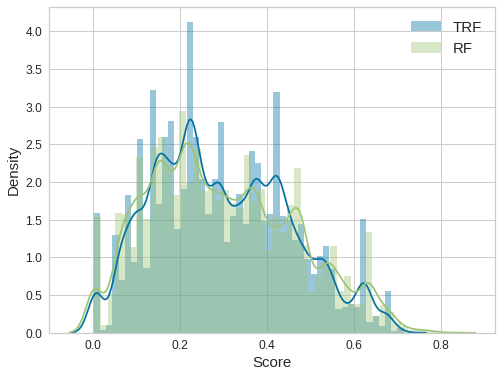

In [80]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [81]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

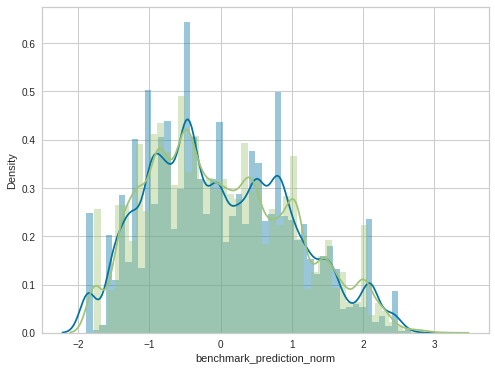

In [82]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(24560, 7)
(36842, 7)


In [84]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

['Age upon Intake']

In [85]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [86]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


In [87]:
# pred_test = gam_challenger.predict(X_test[features])
# print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

# pred_test = gam_benchmark.predict(X_test[features])
# print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

In [88]:
X_test.describe()

,Age upon Intake,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color
count,36842.000000,36842.000000,36842.000000,36842.000000,36842.000000,36842.000000,36842.000000
mean,2.469046,3.427284,5.055100,1.756962,1.643396,1300.036100,254.089192
std,2.713019,0.923702,0.936462,0.652470,1.553432,608.081934,189.938838
min,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.666667,2.000000,5.000000,1.000000,0.000000,1094.250000,63.000000
50%,2.000000,4.000000,5.000000,2.000000,1.000000,1160.000000,201.000000
75%,3.000000,4.000000,5.000000,2.000000,2.000000,1765.000000,457.000000
max,13.000000,5.000000,9.000000,4.000000,5.000000,2621.000000,593.000000


In [89]:
import matplotlib as mpl 
mpl.rcParams['agg.path.chunksize'] = 10000

Age upon Intake
0


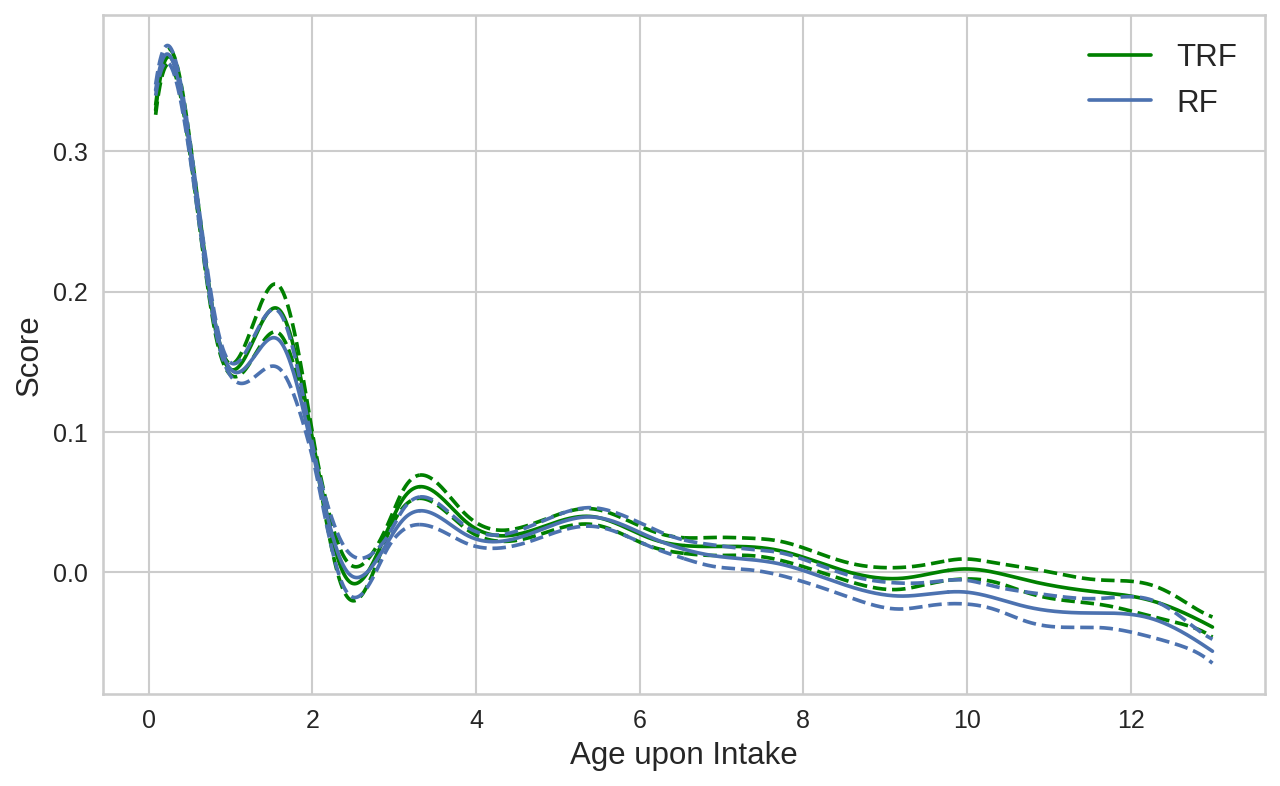

<Figure size 576x432 with 0 Axes>

In [90]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    #XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
    #XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

No handles with labels found to put in legend.


Intake Type


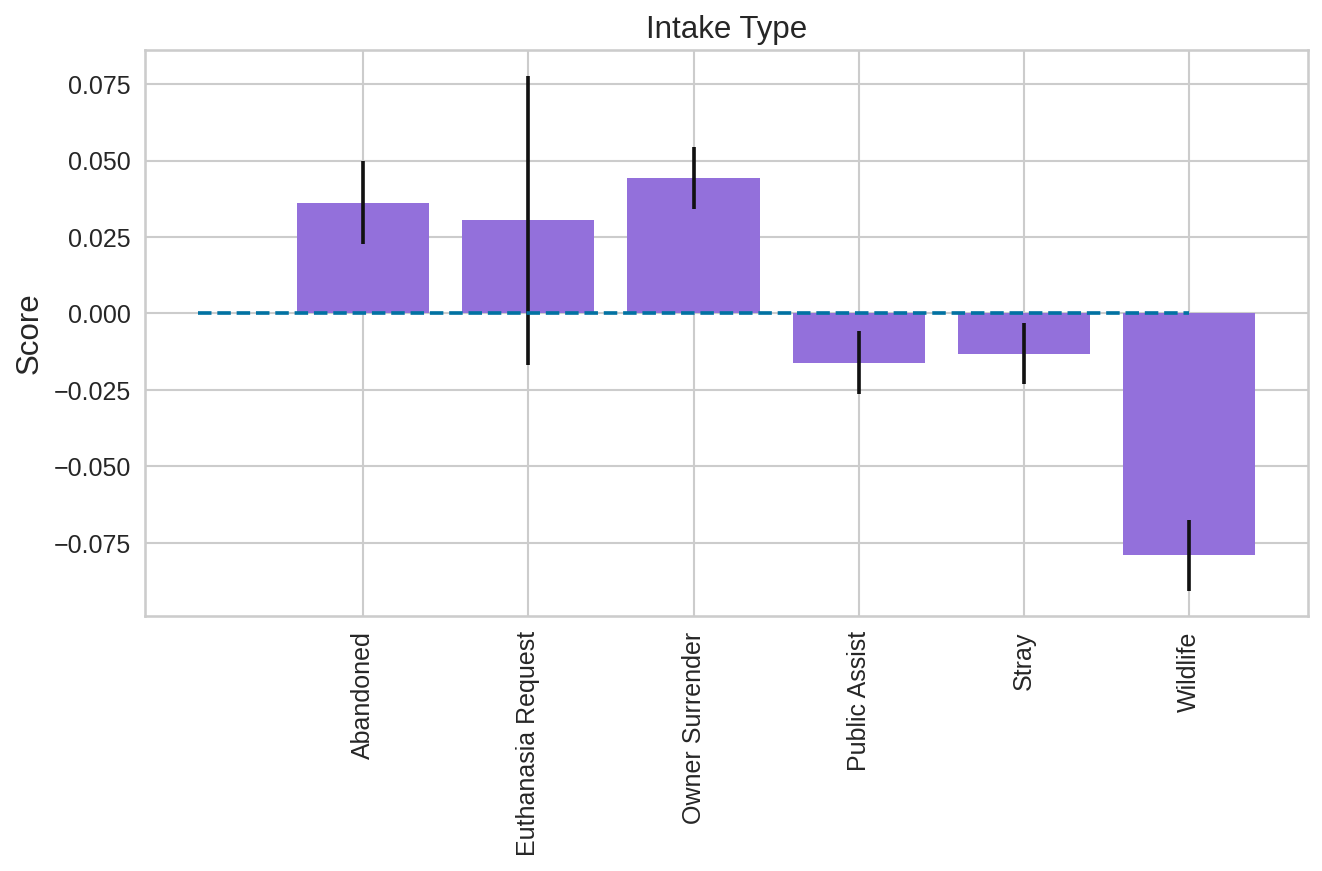

No handles with labels found to put in legend.


Intake Condition


<Figure size 576x432 with 0 Axes>

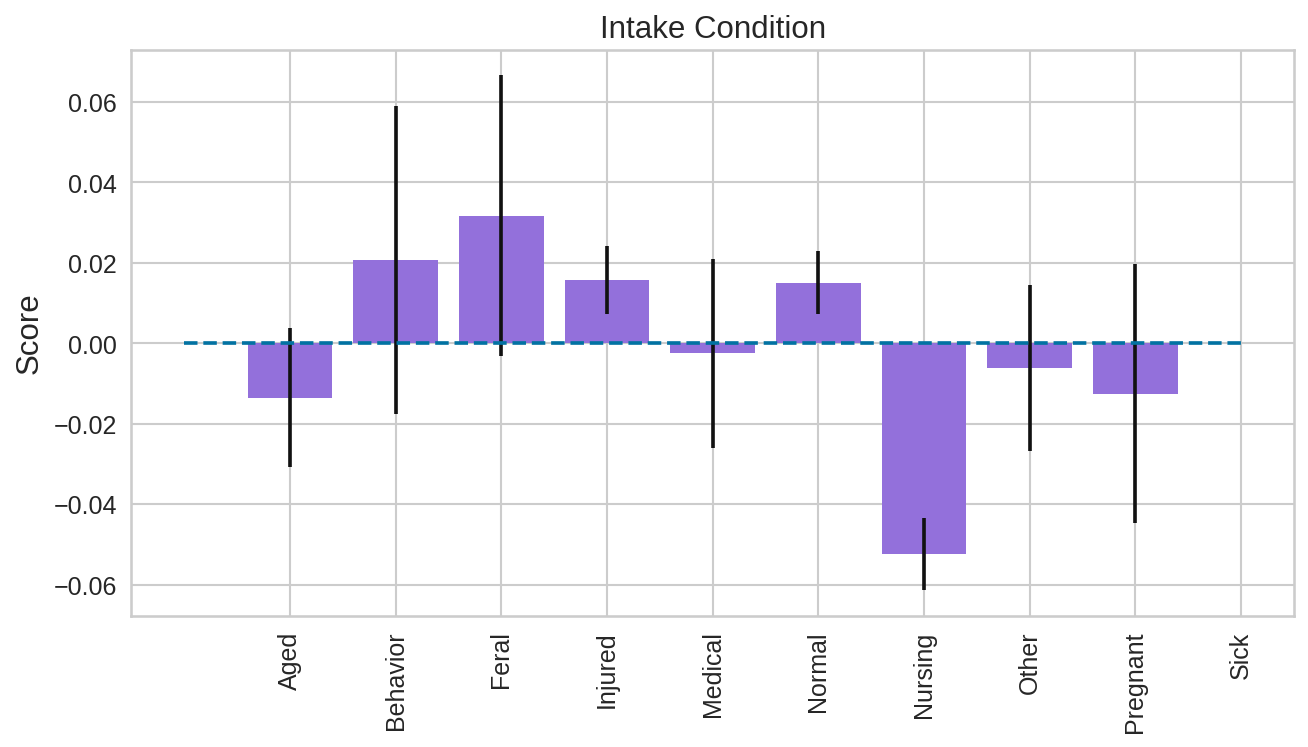

No handles with labels found to put in legend.


Animal Type


<Figure size 576x432 with 0 Axes>

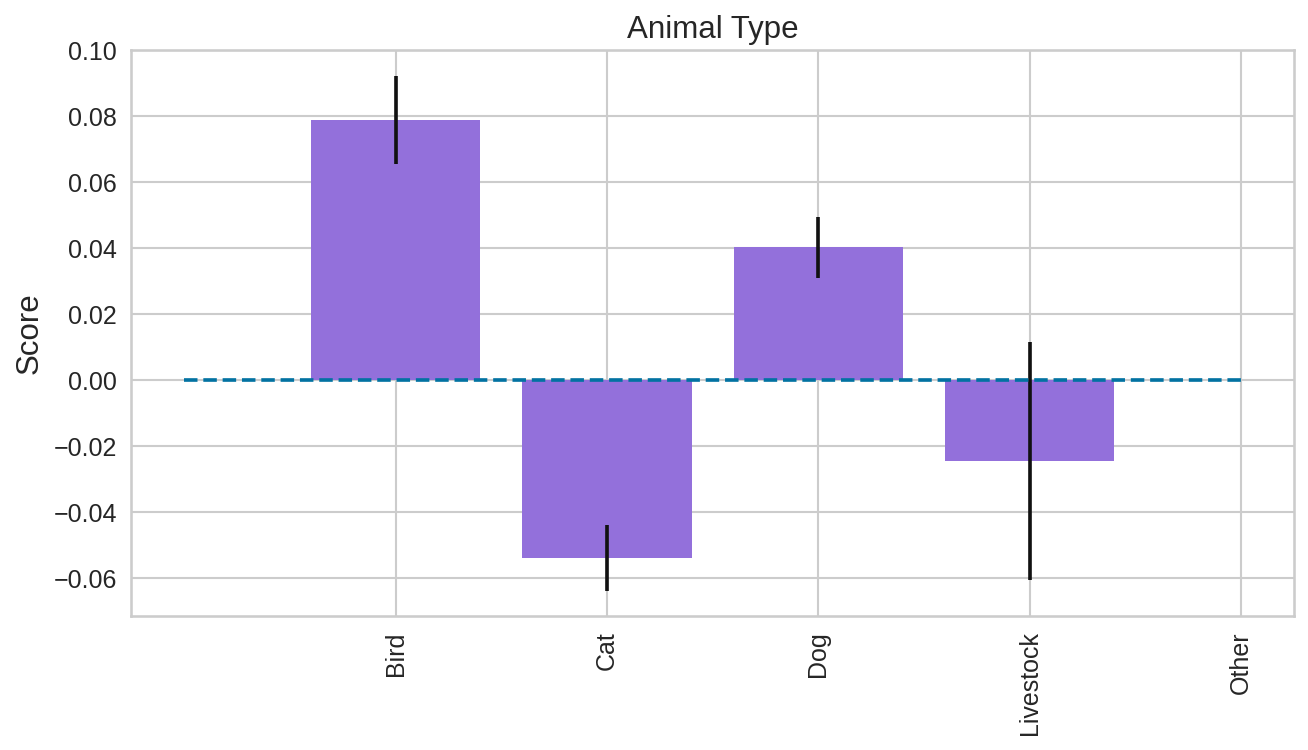

No handles with labels found to put in legend.


Sex upon Intake


<Figure size 576x432 with 0 Axes>

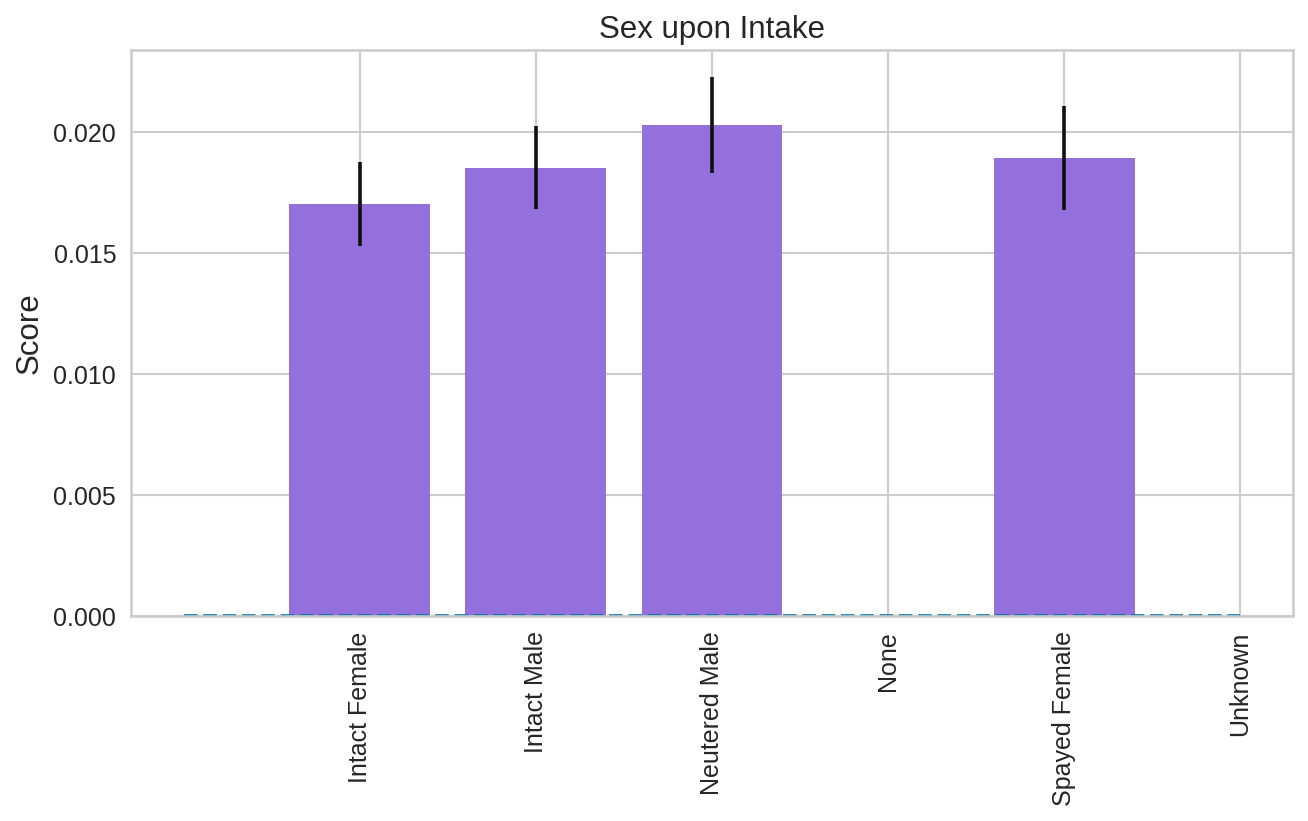

Breed
Color


<Figure size 576x432 with 0 Axes>

In [91]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        #try:
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        agg = data.groupby(feat).mean()

        impact_plot = plt.bar([i for i in range(len(agg))],
                              agg["Mean Impact"],
                              yerr=agg[["low", "high"]].values.transpose(),
                              color="#9370DB",
                              capsize=7)

        plt.title(feat, fontsize=15)
        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)

        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

        plt.show()
        plt.clf()
#         except:
#             print("No plot for {}".format(feat))
plt.show()

Intake Type


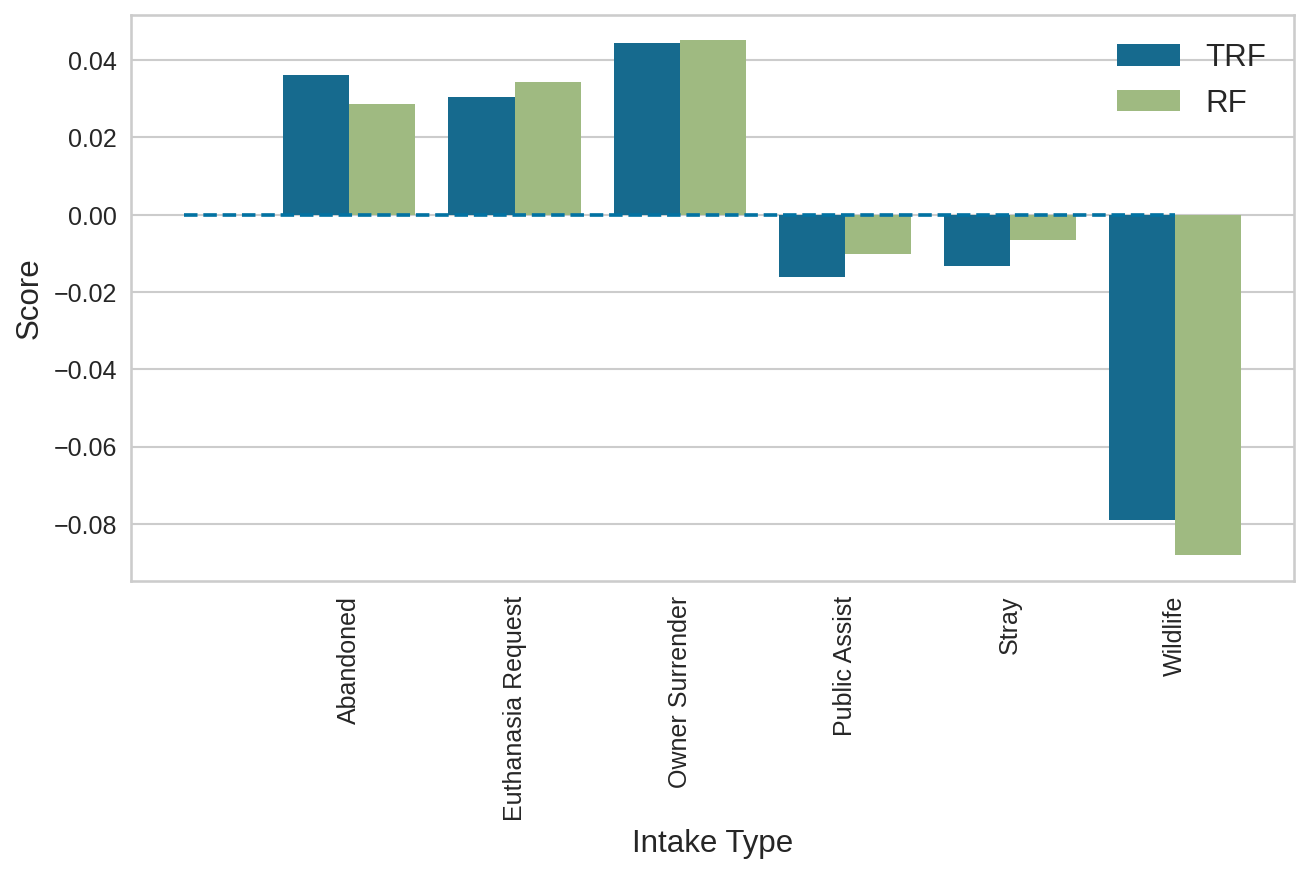

Intake Condition


<Figure size 576x432 with 0 Axes>

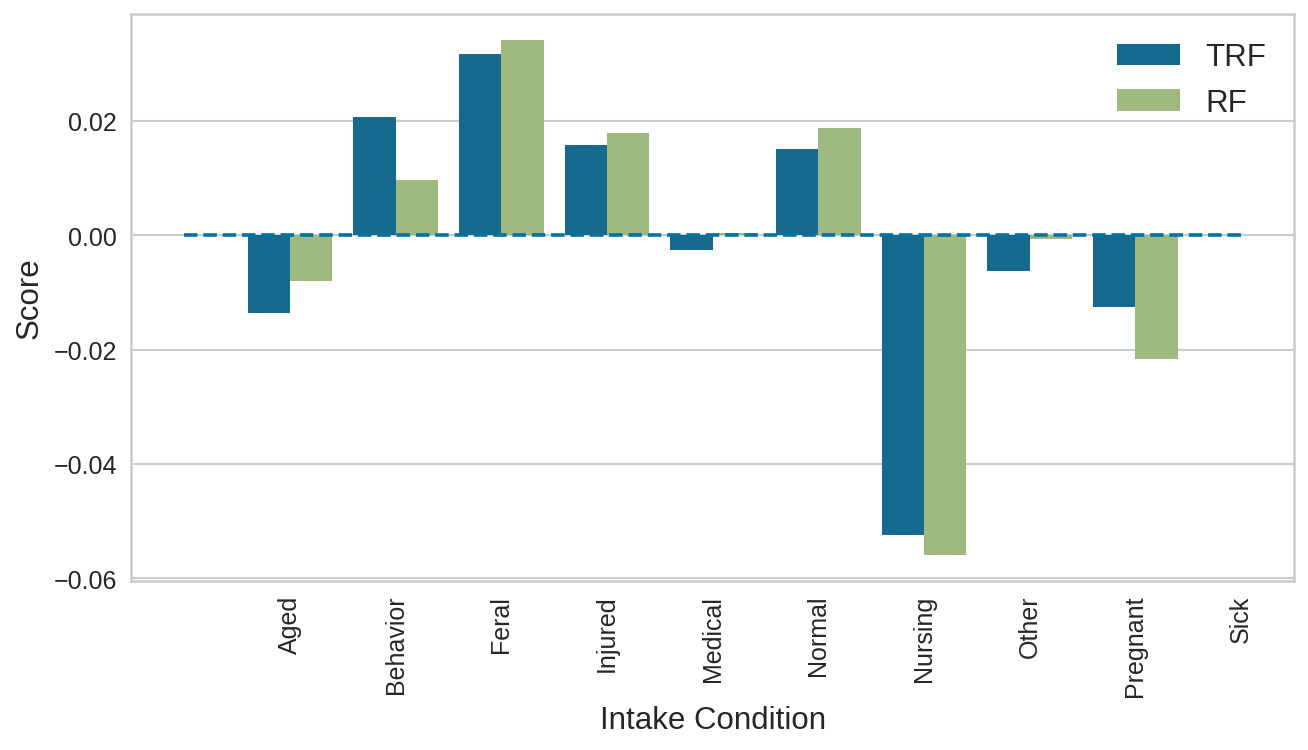

Animal Type


<Figure size 576x432 with 0 Axes>

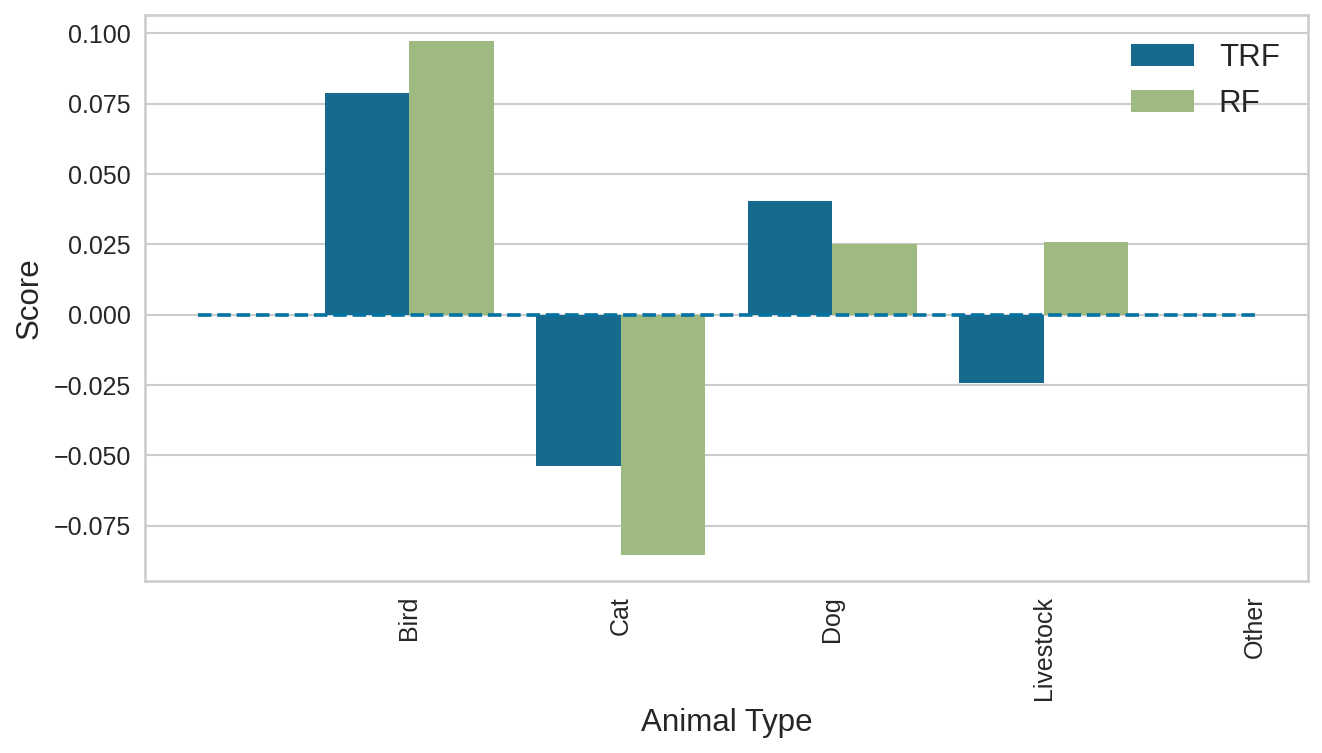

Sex upon Intake


<Figure size 576x432 with 0 Axes>

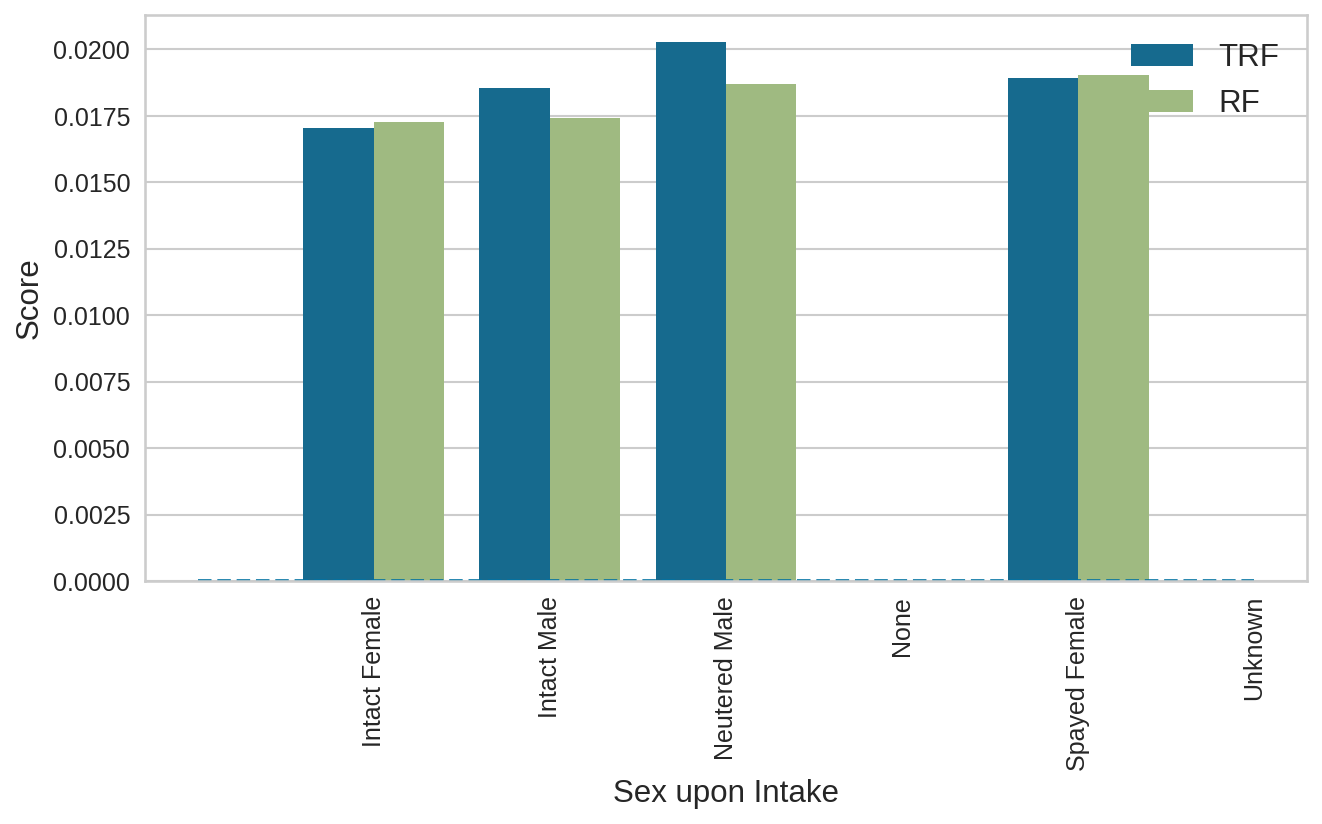

Breed
Color


<Figure size 576x432 with 0 Axes>

In [92]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2445, 2444, X_test.values[:, 5].astype(int))

        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [93]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [94]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

challenger_params = challenger_opt_param.copy()
challenger_params.pop("min_sample_periods")
for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        min_sample_periods=min_sample_periods,
                                        multi=True,
                                        **challenger_params)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

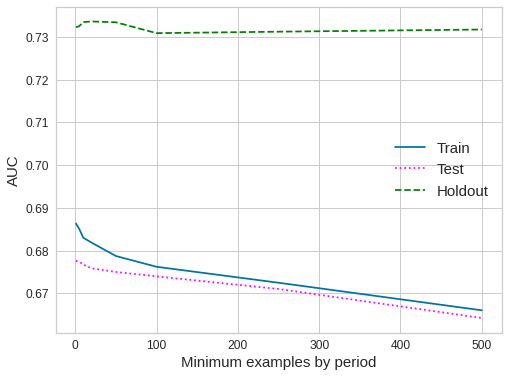

In [95]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

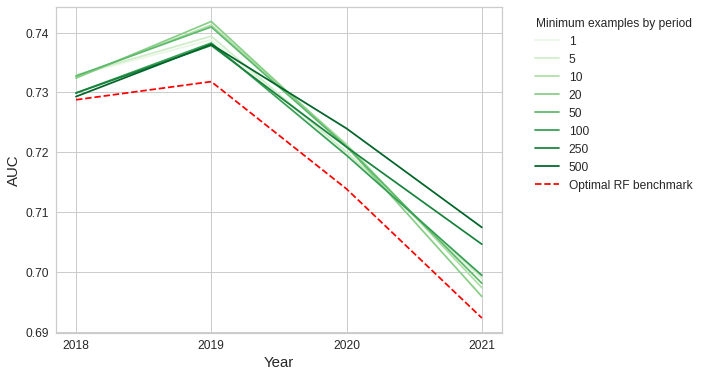

In [96]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [97]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

bench_params = benchmark_opt_param.copy()
bench_params.pop("min_sample_periods")

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       min_sample_periods=training_segments * min_sample_periods,
                                       **bench_params)
    
    
    model.fit(train[features + [DUMMY_TIME_COLUMN]],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

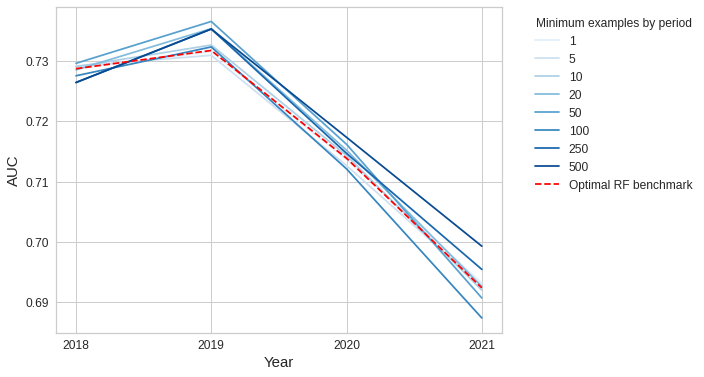

In [98]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

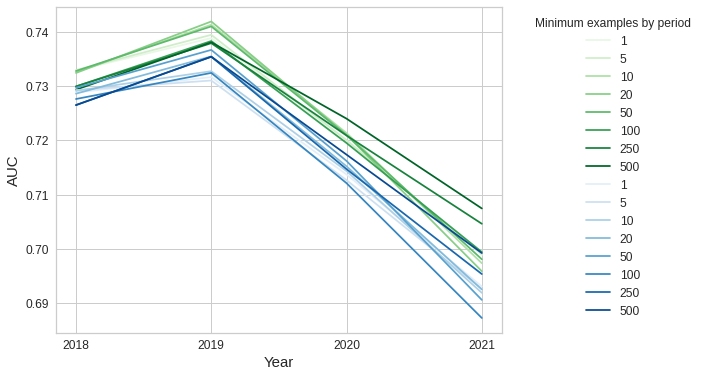

In [99]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

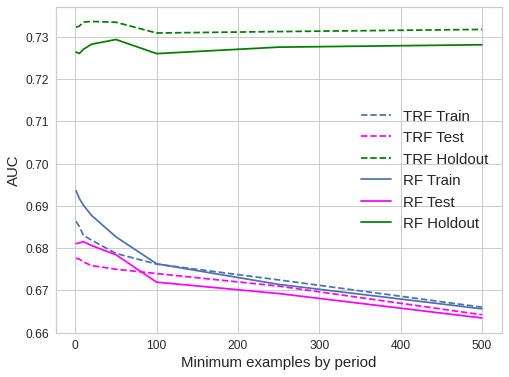

In [100]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

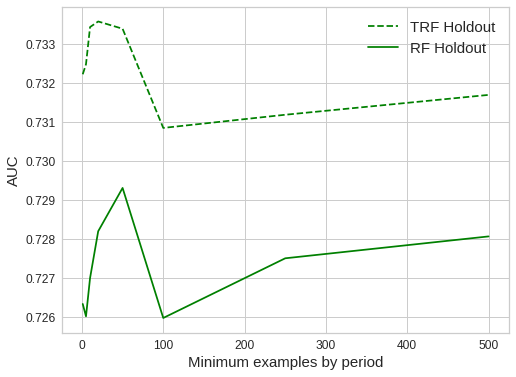

In [101]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [102]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [103]:
domain_data = pd.concat([train, test, out_of_time])

In [104]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [105]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6684,0.6886,0.7742,0.7067,0.7389,0.2874,0.2897
1,0.6655,0.6853,0.7730,0.7040,0.7369,0.2806,0.2830
2,0.6717,0.6866,0.7953,0.7023,0.7459,0.2871,0.2916
3,0.6732,0.6902,0.7952,0.7039,0.7467,0.2911,0.2954
4,0.6691,0.6900,0.7835,0.7038,0.7415,0.2854,0.2885
Mean,0.6696,0.6881,0.7842,0.7041,0.7420,0.2863,0.2896
SD,0.0027,0.0019,0.0097,0.0014,0.0038,0.0034,0.0041


In [106]:
domain_model = tuned_domain_rf

In [107]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)

In [108]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [109]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.683725148559403

## Other optimization design for the RF

In [110]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

2017

In [111]:
posfix = str(last_time_segment_in_train)

In [112]:
new_train = in_time[in_time["Year"] < last_time_segment_in_train]
new_validation = in_time[in_time["Year"] == last_time_segment_in_train]

In [113]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                      optimize="AUC",
                      n_iter=25)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6604,0.7679,0.7819,0.4348,0.5588,0.3176,0.3539
1,0.6670,0.7680,0.7798,0.4405,0.5630,0.3260,0.3609
2,0.6709,0.7840,0.7979,0.4452,0.5715,0.3377,0.3757
3,0.6415,0.7673,0.8031,0.4206,0.5520,0.2989,0.3428
4,0.6532,0.7653,0.7793,0.4283,0.5528,0.3066,0.3435
5,0.6924,0.7775,0.7576,0.4638,0.5754,0.3554,0.3818
6,0.6915,0.7819,0.7556,0.4628,0.5740,0.3534,0.3796
7,0.7082,0.7873,0.7490,0.4806,0.5855,0.3765,0.3985
8,0.6944,0.7878,0.7862,0.4672,0.5861,0.3678,0.3992
9,0.7078,0.7965,0.7680,0.4806,0.5912,0.3821,0.4076


In [114]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0005,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=270, n_jobs=-1, oob_score=False,
                       random_state=44, verbose=0, warm_start=False)

In [115]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [116]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [117]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6610,0.7770,0.7784,0.4426,0.5643,0.3197,0.3540
1,0.6720,0.7737,0.7844,0.4529,0.5743,0.3373,0.3711
2,0.6727,0.7734,0.7676,0.4527,0.5695,0.3328,0.3631
3,0.6631,0.7678,0.7809,0.4446,0.5666,0.3235,0.3580
4,0.6751,0.7713,0.7772,0.4556,0.5745,0.3395,0.3713
5,0.6846,0.7824,0.7668,0.4644,0.5784,0.3500,0.3781
6,0.6924,0.7805,0.7767,0.4726,0.5876,0.3648,0.3935
7,0.7038,0.7880,0.7625,0.4843,0.5923,0.3775,0.4015
8,0.7023,0.8000,0.7832,0.4830,0.5975,0.3817,0.4098
9,0.6801,0.7836,0.7918,0.4611,0.5828,0.3515,0.3855


In [118]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

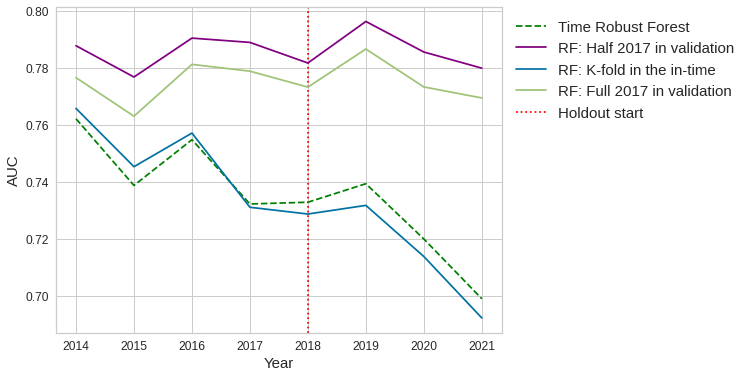

In [119]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()


### Sanity check

In [131]:
challenger_model_sanity = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=250,
                                        min_sample_periods=30,
                                        max_depth=11,
                                        multi=True)

challenger_model_sanity.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction_sanity"] = challenger_model_sanity.predict_proba(train[features])[:, 1]
test["challenger_prediction_sanity"] = challenger_model_sanity.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction_sanity"] = challenger_model_sanity.predict_proba(out_of_time[features])[:, 1]

print(roc_auc_score(train[TARGET], train["challenger_prediction_sanity"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction_sanity"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction_sanity"]))

0.7499461247174584
0.7414143114776137
0.7275091928833789
